<a href="https://colab.research.google.com/github/djbell01/563-DawsonBell/blob/main/HW_Week7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q condacolab
!git clone --single-branch --branch cecam https://github.com/cmelab/hoomd-organics
import condacolab
condacolab.install()

Cloning into 'hoomd-organics'...
remote: Enumerating objects: 3573, done.
remote: Counting objects: 100% (829/829), done.
remote: Compressing objects: 100% (183/183), done.
remote: Total 3573 (delta 674), reused 646 (delta 646), pack-reused 2744 (from 1)
Receiving objects: 100% (3573/3573), 1.53 MiB | 4.52 MiB/s, done.
Resolving deltas: 100% (2461/2461), done.
⏬ Downloading https://github.com/jaimergp/miniforge/releases/download/24.11.2-1_colab/Miniforge3-colab-24.11.2-1_colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:21
🔁 Restarting kernel...


In [ ]:
#!pip install --upgrade ipykernel #breaks things?
import os
os.chdir("hoomd-organics")
!mamba env update -n base -f environment-cpu.yml
!python -m pip install -e .
import warnings
warnings.filterwarnings('ignore')

Channels:
 - conda-forge
Platform: linux-64
Solving environment: / - \ | / - \ | done


==> WARNING: A newer version of conda exists. <==
    current version: 24.11.2
    latest version: 25.1.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



cudatoolkit-11.8.0   | 682.5 MB  | :   0% 0/1 [00:00<?, ?it/s]
gcc_impl_linux-64-14 | 70.1 MB   | :   0% 0/1 [00:00<?, ?it/s]

pillow-11.1.0        | 40.1 MB   | :   0% 0/1 [00:00<?, ?it/s]


libllvm14-14.0.6     | 30.0 MB   | :   0% 0/1 [00:00<?, ?it/s]



libflint-3.1.3.1     | 20.2 MB   | :   0% 0/1 [00:00<?, ?it/s]




rdkit-2024.09.6      | 19.0 MB   | :   0% 0/1 [00:00<?, ?it/s]





parmed-4.3.0         | 18.5 MB   | :   0% 0/1 [00:00<?, ?it/s]






scipy-1.15.2         | 16.4 MB   | :   0% 0/1 [00:00<?, ?it/s]







libclang-cpp14-14.0. | 15.8 MB   | :   0% 0/1 [00:00<?, ?it/s]








pandas-2.2.3         | 15.0 MB   | :   0% 0/1 [00:00<?, ?it/s]









sysroot_linux-64-2.1 | 14.5 MB 

# dt = 0.0005

In [82]:
import hoomd
import numpy
device = hoomd.device.CPU()
seed = numpy.random.randint(1,1e4)
simulation = hoomd.Simulation(device = device, seed = seed)

In [83]:
kT = 1.0
epsilon = 1.0
sigma = 1.0
density = 1.0

In [84]:
import freud
#a is the spacing between particles
a = 1/(density**(1/3.0))
#We want a number of particles N in our system.
#Since we will be replicating the system in 3 dimensions, the number of unit cells we need is N^(1/3)
num_replicas = 20
N_particles = num_replicas**3
grid_particles = freud.data.UnitCell([a,a,a,0,0,0],[[0,0,0]]).generate_system(num_replicas)
box_length = grid_particles[0].Lx

In [85]:
import gsd.hoomd
frame = gsd.hoomd.Frame()
frame.particles.N = N_particles
frame.particles.position = grid_particles[1]
frame.configuration.box = [box_length,box_length,box_length,0,0,0]

#Types of particles define different interactions. In an atomistic simulation these might be C, O, and H.
#in a coarse-grained simulation we can give them a simple name like A
frame.particles.typeid = [0]*N_particles
frame.particles.types = ['A']

#Finally, save our initial state:
with gsd.hoomd.open(name='initial_state.gsd', mode='w') as f:
    f.append(frame)

In [86]:
simulation.create_state_from_gsd(filename='initial_state.gsd')

In [87]:
integrator = hoomd.md.Integrator(dt = 0.0005)
nve = hoomd.md.methods.NVE(filter = hoomd.filter.All())
integrator.methods.append(nve)

In [88]:
cell = hoomd.md.nlist.Cell(buffer=0.4)

#Define the force for different particles
lj = hoomd.md.pair.LJ(nlist=cell)

lj.params[('A', 'A')] = {"epsilon":epsilon, "sigma":sigma}

lj.r_cut[('A', 'A')] = 2.5*sigma

In [89]:
integrator.forces.append(lj)
simulation.operations.integrator = integrator

In [90]:
simulation.state.thermalize_particle_momenta(filter=hoomd.filter.All(), kT=1.0)
thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(
    filter=hoomd.filter.All()
)

simulation.operations.computes.append(thermodynamic_properties)
logger = hoomd.logging.Logger(categories=['scalar'])
logger.add(thermodynamic_properties, quantities=['potential_energy','kinetic_energy'])
energy_table = hoomd.write.Table(trigger=hoomd.trigger.Periodic(period=int(1)), logger=logger, output=open('dt_0.0005.csv','w'))
simulation.operations.writers.append(energy_table)

In [91]:
simulation.run(10000)

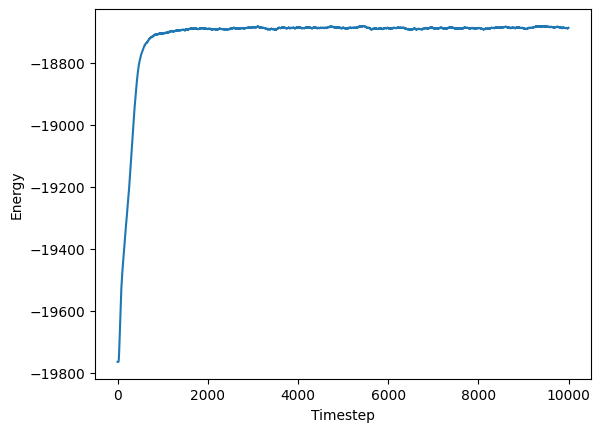

In [92]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('dt_0.0005.csv',delim_whitespace=True)
df['tot_energy'] = df['md.compute.ThermodynamicQuantities.potential_energy'] + df['md.compute.ThermodynamicQuantities.kinetic_energy']

plt.plot(df.index,df['tot_energy'])
plt.xlabel('Timestep')
plt.ylabel('Energy')
plt.show()

# dt = 0.001

In [93]:
del simulation

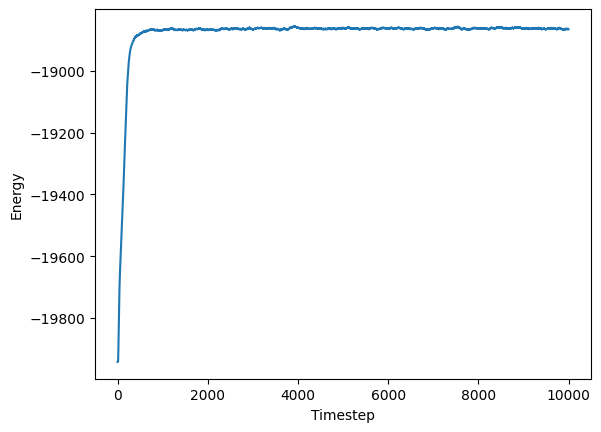

In [94]:
import hoomd
import numpy
device = hoomd.device.CPU()
seed = numpy.random.randint(1,1e4)
simulation = hoomd.Simulation(device = device, seed = seed)

kT = 1.0
epsilon = 1.0
sigma = 1.0
density = 1.0
dt = 0.001

import freud
#a is the spacing between particles
a = 1/(density**(1/3.0))
#We want a number of particles N in our system.
#Since we will be replicating the system in 3 dimensions, the number of unit cells we need is N^(1/3)
num_replicas = 20
N_particles = num_replicas**3
grid_particles = freud.data.UnitCell([a,a,a,0,0,0],[[0,0,0]]).generate_system(num_replicas)
box_length = grid_particles[0].Lx

import gsd.hoomd
frame = gsd.hoomd.Frame()
frame.particles.N = N_particles
frame.particles.position = grid_particles[1]
frame.configuration.box = [box_length,box_length,box_length,0,0,0]

#Types of particles define different interactions. In an atomistic simulation these might be C, O, and H.
#in a coarse-grained simulation we can give them a simple name like A
frame.particles.typeid = [0]*N_particles
frame.particles.types = ['A']

#Finally, save our initial state:
with gsd.hoomd.open(name='initial_state.gsd', mode='w') as f:
    f.append(frame)

simulation.create_state_from_gsd(filename='initial_state.gsd')

integrator = hoomd.md.Integrator(dt = dt)
nve = hoomd.md.methods.NVE(filter = hoomd.filter.All())
integrator.methods.append(nve)

cell = hoomd.md.nlist.Cell(buffer=0.4)

#Define the force for different particles
lj = hoomd.md.pair.LJ(nlist=cell)

lj.params[('A', 'A')] = {"epsilon":epsilon, "sigma":sigma}

lj.r_cut[('A', 'A')] = 2.5*sigma

integrator.forces.append(lj)
simulation.operations.integrator = integrator

simulation.state.thermalize_particle_momenta(filter=hoomd.filter.All(), kT=1.0)
thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(
    filter=hoomd.filter.All()
)

simulation.operations.computes.append(thermodynamic_properties)
logger = hoomd.logging.Logger(categories=['scalar'])
logger.add(thermodynamic_properties, quantities=['potential_energy','kinetic_energy'])
energy_table = hoomd.write.Table(trigger=hoomd.trigger.Periodic(period=int(1)), logger=logger, output=open(f'dt_{str(dt)}.csv','w'))
simulation.operations.writers.append(energy_table)
simulation.run(10000)

df = pd.read_csv(f'dt_{str(dt)}.csv',delim_whitespace=True)
df['tot_energy'] = df['md.compute.ThermodynamicQuantities.potential_energy'] + df['md.compute.ThermodynamicQuantities.kinetic_energy']

plt.plot(df.index,df['tot_energy'])
plt.xlabel('Timestep')
plt.ylabel('Energy')
plt.show()

# dt = 0.005

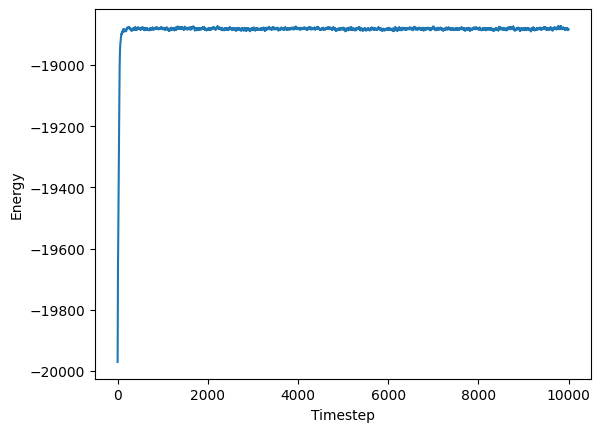

In [95]:
del simulation

device = hoomd.device.CPU()
seed = numpy.random.randint(1,1e4)
simulation = hoomd.Simulation(device = device, seed = seed)

kT = 1.0
epsilon = 1.0
sigma = 1.0
density = 1.0
dt = 0.005

import freud
#a is the spacing between particles
a = 1/(density**(1/3.0))
#We want a number of particles N in our system.
#Since we will be replicating the system in 3 dimensions, the number of unit cells we need is N^(1/3)
num_replicas = 20
N_particles = num_replicas**3
grid_particles = freud.data.UnitCell([a,a,a,0,0,0],[[0,0,0]]).generate_system(num_replicas)
box_length = grid_particles[0].Lx

import gsd.hoomd
frame = gsd.hoomd.Frame()
frame.particles.N = N_particles
frame.particles.position = grid_particles[1]
frame.configuration.box = [box_length,box_length,box_length,0,0,0]

#Types of particles define different interactions. In an atomistic simulation these might be C, O, and H.
#in a coarse-grained simulation we can give them a simple name like A
frame.particles.typeid = [0]*N_particles
frame.particles.types = ['A']

#Finally, save our initial state:
with gsd.hoomd.open(name='initial_state.gsd', mode='w') as f:
    f.append(frame)

simulation.create_state_from_gsd(filename='initial_state.gsd')

integrator = hoomd.md.Integrator(dt = dt)
nve = hoomd.md.methods.NVE(filter = hoomd.filter.All())
integrator.methods.append(nve)

cell = hoomd.md.nlist.Cell(buffer=0.4)

#Define the force for different particles
lj = hoomd.md.pair.LJ(nlist=cell)

lj.params[('A', 'A')] = {"epsilon":epsilon, "sigma":sigma}

lj.r_cut[('A', 'A')] = 2.5*sigma

integrator.forces.append(lj)
simulation.operations.integrator = integrator

simulation.state.thermalize_particle_momenta(filter=hoomd.filter.All(), kT=1.0)
thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(
    filter=hoomd.filter.All()
)

simulation.operations.computes.append(thermodynamic_properties)
logger = hoomd.logging.Logger(categories=['scalar'])
logger.add(thermodynamic_properties, quantities=['potential_energy','kinetic_energy'])
energy_table = hoomd.write.Table(trigger=hoomd.trigger.Periodic(period=int(1)), logger=logger, output=open(f'dt_{str(dt)}.csv','w'))
simulation.operations.writers.append(energy_table)
simulation.run(10000)

df = pd.read_csv(f'dt_{str(dt)}.csv',delim_whitespace=True)
df['tot_energy'] = df['md.compute.ThermodynamicQuantities.potential_energy'] + df['md.compute.ThermodynamicQuantities.kinetic_energy']

plt.plot(df.index,df['tot_energy'])
plt.xlabel('Timestep')
plt.ylabel('Energy')
plt.show()

# dt = 0.01

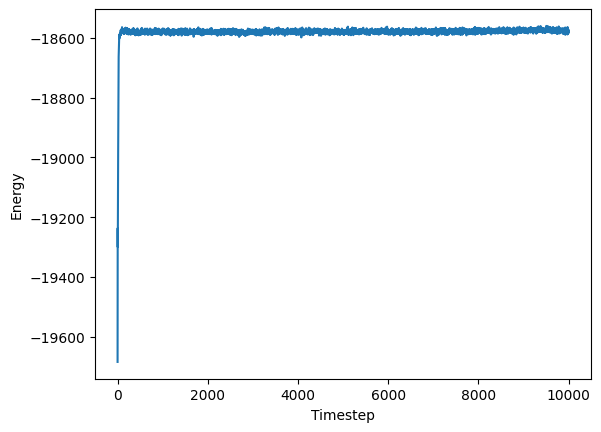

In [96]:
del simulation

device = hoomd.device.CPU()
seed = numpy.random.randint(1,1e4)
simulation = hoomd.Simulation(device = device, seed = seed)

kT = 1.0
epsilon = 1.0
sigma = 1.0
density = 1.0
dt = 0.01

import freud
#a is the spacing between particles
a = 1/(density**(1/3.0))
#We want a number of particles N in our system.
#Since we will be replicating the system in 3 dimensions, the number of unit cells we need is N^(1/3)
num_replicas = 20
N_particles = num_replicas**3
grid_particles = freud.data.UnitCell([a,a,a,0,0,0],[[0,0,0]]).generate_system(num_replicas)
box_length = grid_particles[0].Lx

import gsd.hoomd
frame = gsd.hoomd.Frame()
frame.particles.N = N_particles
frame.particles.position = grid_particles[1]
frame.configuration.box = [box_length,box_length,box_length,0,0,0]

#Types of particles define different interactions. In an atomistic simulation these might be C, O, and H.
#in a coarse-grained simulation we can give them a simple name like A
frame.particles.typeid = [0]*N_particles
frame.particles.types = ['A']

#Finally, save our initial state:
with gsd.hoomd.open(name='initial_state.gsd', mode='w') as f:
    f.append(frame)

simulation.create_state_from_gsd(filename='initial_state.gsd')

integrator = hoomd.md.Integrator(dt = dt)
nve = hoomd.md.methods.NVE(filter = hoomd.filter.All())
integrator.methods.append(nve)

cell = hoomd.md.nlist.Cell(buffer=0.4)

#Define the force for different particles
lj = hoomd.md.pair.LJ(nlist=cell)

lj.params[('A', 'A')] = {"epsilon":epsilon, "sigma":sigma}

lj.r_cut[('A', 'A')] = 2.5*sigma

integrator.forces.append(lj)
simulation.operations.integrator = integrator

simulation.state.thermalize_particle_momenta(filter=hoomd.filter.All(), kT=1.0)
thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(
    filter=hoomd.filter.All()
)

simulation.operations.computes.append(thermodynamic_properties)
logger = hoomd.logging.Logger(categories=['scalar'])
logger.add(thermodynamic_properties, quantities=['potential_energy','kinetic_energy'])
energy_table = hoomd.write.Table(trigger=hoomd.trigger.Periodic(period=int(1)), logger=logger, output=open(f'dt_{str(dt)}.csv','w'))
simulation.operations.writers.append(energy_table)
simulation.run(10000)

df = pd.read_csv(f'dt_{str(dt)}.csv',delim_whitespace=True)
df['tot_energy'] = df['md.compute.ThermodynamicQuantities.potential_energy'] + df['md.compute.ThermodynamicQuantities.kinetic_energy']

plt.plot(df.index,df['tot_energy'])
plt.xlabel('Timestep')
plt.ylabel('Energy')
plt.show()

# dt = 0.05

In [99]:
del simulation

device = hoomd.device.CPU()
seed = numpy.random.randint(1,1e4)
simulation = hoomd.Simulation(device = device, seed = seed)

kT = 1.0
epsilon = 1.0
sigma = 1.0
density = 1.0
dt = 0.05

import freud
#a is the spacing between particles
a = 1/(density**(1/3.0))
#We want a number of particles N in our system.
#Since we will be replicating the system in 3 dimensions, the number of unit cells we need is N^(1/3)
num_replicas = 20
N_particles = num_replicas**3
grid_particles = freud.data.UnitCell([a,a,a,0,0,0],[[0,0,0]]).generate_system(num_replicas)
box_length = grid_particles[0].Lx

import gsd.hoomd
frame = gsd.hoomd.Frame()
frame.particles.N = N_particles
frame.particles.position = grid_particles[1]
frame.configuration.box = [box_length,box_length,box_length,0,0,0]

#Types of particles define different interactions. In an atomistic simulation these might be C, O, and H.
#in a coarse-grained simulation we can give them a simple name like A
frame.particles.typeid = [0]*N_particles
frame.particles.types = ['A']

#Finally, save our initial state:
with gsd.hoomd.open(name='initial_state.gsd', mode='w') as f:
    f.append(frame)

simulation.create_state_from_gsd(filename='initial_state.gsd')

integrator = hoomd.md.Integrator(dt = dt)
nve = hoomd.md.methods.NVE(filter = hoomd.filter.All())
integrator.methods.append(nve)

cell = hoomd.md.nlist.Cell(buffer=0.4)

#Define the force for different particles
lj = hoomd.md.pair.LJ(nlist=cell)

lj.params[('A', 'A')] = {"epsilon":epsilon, "sigma":sigma}

lj.r_cut[('A', 'A')] = 2.5*sigma

integrator.forces.append(lj)
simulation.operations.integrator = integrator

simulation.state.thermalize_particle_momenta(filter=hoomd.filter.All(), kT=1.0)
thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(
    filter=hoomd.filter.All()
)

simulation.operations.computes.append(thermodynamic_properties)
logger = hoomd.logging.Logger(categories=['scalar'])
logger.add(thermodynamic_properties, quantities=['potential_energy','kinetic_energy'])
energy_table = hoomd.write.Table(trigger=hoomd.trigger.Periodic(period=int(1)), logger=logger, output=open(f'dt_{str(dt)}.csv','w'))
simulation.operations.writers.append(energy_table)
simulation.run(10000)

df = pd.read_csv(f'dt_{str(dt)}.csv',delim_whitespace=True)
df['tot_energy'] = df['md.compute.ThermodynamicQuantities.potential_energy'] + df['md.compute.ThermodynamicQuantities.kinetic_energy']

plt.plot(df.index,df['tot_energy'])
plt.xlabel('Timestep')
plt.ylabel('Energy')
plt.show()

**ERROR**: Particle with unique tag 3810 is no longer in the simulation box.

Cartesian coordinates: 
x: -146.416 y: -2.20884 z: 66.7605
Fractional coordinates: 
f.x: -6.82082 f.y: 0.389558 f.z: 3.83802
Local box lo: (-10, -10, -10)
          hi: (10, 10, 10)


RuntimeError: Error computing cell list


### Time step of 0.05 is too big, particles almost immediately leave the simulation box and HOOMD throws an error.